# Fully Dynamic k-center Clustering

## Parsing

This section has to be runned only once; its role is to parse the data and create a .hdf5 dataset with three fields: one for the timestamp, one for the latitude, one for the longitude. We will use this file in the following sections.

In [1]:
import h5py
def parse_input(path):
    dataset = h5py.File("dataset.hdf5", "w")
    timestamps = dataset.create_dataset("timestamps", (1000000,), dtype='i')
    latitudes = dataset.create_dataset("latitudes", (1000000,), dtype='f')
    longitudes = dataset.create_dataset("longitudes", (1000000,), dtype='f')
    f = open(path,'r')
    for i, line in enumerate(f):
        line = line.split()
        timestamps[i] = int(line[0])
        latitudes[i] = float(line[1])
        longitudes[i] = float(line[2])
    dataset.close()

In [2]:
parse_input('dataset/twitter_1000000.txt')

## Data visualization

Just to check that our geographical data look relevant, i.e that it "coincides" with a world map (at least on the part of the world that are conneted to Twitter!)

In [5]:
import h5py
f = h5py.File('dataset.hdf5', 'r')

In [6]:
timestamps = f['timestamps']
latitudes = f['latitudes']
longitudes = f['longitudes']
for i in range(0, 10):
    print(latitudes[i], longitudes[i])

(0.37526667, 52.263897)
(121.03524, 14.651666)
(-61.205151, -27.213259)
(101.69062, 3.0527644)
(12.3267, 45.438599)
(135.5036, 34.680218)
(139.75256, 35.654442)
(139.77625, 35.713306)
(4.0833302, 48.299999)
(103.85493, 1.300463)


In [7]:
dataset = list(zip(latitudes, longitudes))
for i in range(0, 10):
    print(dataset[i])

(0.37526667, 52.263897)
(121.03524, 14.651666)
(-61.205151, -27.213259)
(101.69062, 3.0527644)
(12.3267, 45.438599)
(135.5036, 34.680218)
(139.75256, 35.654442)
(139.77625, 35.713306)
(4.0833302, 48.299999)
(103.85493, 1.300463)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random
sample_dataset = random.sample(dataset, 4000)
sample_latitudes = [sample[0] for sample in sample_dataset]
sample_longitudes = [sample[1] for sample in sample_dataset]

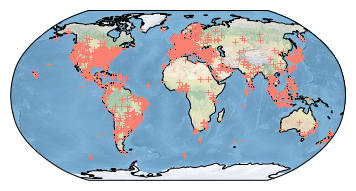

In [9]:
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.stock_img()
ax.coastlines()
plt.plot(sample_latitudes, sample_longitudes, '+', transform=ccrs.PlateCarree(), color='salmon')
plt.show()

## Basic static algorithm 

### Definition of the metric

Here we define a metric that is consistent with the data we deal with : the Haversine distance, which is basically the number of kilometers between two points located with their GPS coordinates.

In [10]:
import math

def Haversine(point, neighbor):
    lat1 = point[0]
    lat2 = neighbor[0]
    lon1 = point[1]
    lon2 = neighbor[1]
    R=6371000                             
    phi_1=math.radians(lat1)
    phi_2=math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi/2.0)**2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda/2.0)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        
    return R*c/1000

In [11]:
Haversine(dataset[0], dataset[1])
Haversine(dataset[0], dataset[2])

9483.092886325172

### Computation of the Betas

In [12]:
import numpy as np

id_to_coords = {i : point for i, point in enumerate(dataset)}

def max_and_min_dists(id_to_coords, sample):
    max_dist = 0
    min_dist = np.infty
    n = len(sample)
    for i in range(0, n-1):
        point = id_to_coords[sample[i]]
        for j in range(i+1, n):
            neighbor = id_to_coords[sample[j]]
            print(point, neighbor)
            distance = Haversine(point, neighbor)
            if distance > max_dist:
                max_dist = distance
            if distance < min_dist:
                min_dist = distance
    return max_dist, min_dist

In [13]:
"""maxima, minima = [], []
for i in range(0, 10):
    print('computing on sample ', i)
    sample = random.sample(list(range(0, 1000000)), 5000)
    maximum, minimum = max_and_min_dists(id_to_coords, sample)
    maxima.append(maximum)
    minima.append(minimum)
print(max(maxima))
print(min(minima))"""

"maxima, minima = [], []\nfor i in range(0, 10):\n    print('computing on sample ', i)\n    sample = random.sample(list(range(0, 1000000)), 5000)\n    maximum, minimum = max_and_min_dists(id_to_coords, sample)\n    maxima.append(maximum)\n    minima.append(minimum)\nprint(max(maxima))\nprint(min(minima))"

In [14]:
def compute_betas(d_min, d_max, eps):
    betas = []
    i_min = int(math.ceil(math.log(d_min)/math.log(1+eps)))
    i_max = int(math.floor(math.log(d_max)/math.log(1+eps)))
    for i in range(i_min, i_max+1):
        betas.append((1+eps)**i)
    return betas

In [15]:
betas = compute_betas(1, 20000, 0.5)
print('minimum beta : ', betas[0])
print('maximum beta : ', betas[-1])
print('number of betas : ', len(betas))

('minimum beta : ', 1.0)
('maximum beta : ', 16834.112196028233)
('number of betas : ', 25)


### Static clustering

In [73]:
def build_cluster(center_id, beta, dataset_ids, clusters):
    center = id_to_coords[center_id]
    clusters[center_id] = center_id
    i = 0
    k = 0
    while True:
        if i >= len(dataset_ids):
            break      
        k += 1
        point_id = dataset_ids[i]
        if point_id != center_id:
            distance = Haversine(center, id_to_coords[point_id])
            if distance <= 2*beta:
                clusters[point_id] = (center_id)
                dataset_ids.remove(point_id)
            else:
                i += 1
        else:
            dataset_ids.remove(point_id)
    print(str(k) + ' points have been scanned ')
    print(str(len(dataset_ids)) +' points remain to be affected')
    print('')
    return dataset_ids, clusters

In [74]:
from copy import deepcopy

def build_beta_clustering(k, beta, dataset_ids):
    clusters = {point_id : -1 for point_id in dataset_ids}
    order = []
    d = deepcopy(dataset_ids)
    for i in range(0, k):
        if not d:
            break
        center_id = random.choice(d)
        order.append(center_id)
        d.remove(center_id)
        print('Building cluster ' + str(i+1) + ' whose center is ' + str(center_id))
        d, clusters = build_cluster(center_id, beta, d, clusters)
    return clusters, order

In [75]:
def build_whole_clustering(k, betas, dataset_ids):
    clustering, ordering = {}, {}
    for beta in betas:
        print('Computing for beta = ' + str(beta))
        print('')
        clusters, order  = build_beta_clustering(k, beta, dataset_ids)
        ordering[beta] = order
        clustering[beta] = clusters
        print('##########################################')
    return clustering, ordering

In [78]:
beta_test = 1500
clustering, ordering = build_whole_clustering(11, [beta_test], random.sample(list(range(0, 1000000)), 20000))
print(ordering)

Computing for beta = 1500

Building cluster 1 whose center is 262512
19999 points have been scanned 
17337 points remain to be affected

Building cluster 2 whose center is 527913
17336 points have been scanned 
11014 points remain to be affected

Building cluster 3 whose center is 674311
11013 points have been scanned 
9064 points remain to be affected

Building cluster 4 whose center is 559407
9063 points have been scanned 
6350 points remain to be affected

Building cluster 5 whose center is 71093
6349 points have been scanned 
6148 points remain to be affected

Building cluster 6 whose center is 183576
6147 points have been scanned 
4449 points remain to be affected

Building cluster 7 whose center is 316554
4448 points have been scanned 
1909 points remain to be affected

Building cluster 8 whose center is 8678
1908 points have been scanned 
483 points remain to be affected

Building cluster 9 whose center is 82993
482 points have been scanned 
329 points remain to be affected

Bui

In [79]:
from collections import defaultdict

def plot_cluster_sizes(clusters):
    counts = defaultdict(int)
    for point_id, center_id in clusters.items():
        counts[center_id] += 1
    plt.bar(np.arange(len(counts.keys())), counts.values())
    plt.ylabel('Number of points')
    plt.xlabel('Clusters')
    plt.show()

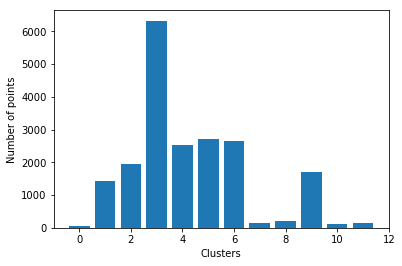

In [80]:
plot_cluster_sizes(clustering[beta_test])

In [81]:
def plot_clusters_on_map(clusters, order):
    centers_ids = order
    col = ['salmon', 'plum', 'lime', 'lavender', 'goldenrod', 'aquamarine', 'orangered', 'darkgreen', 'sienna', 'navy', 'crimson', 'yellow' ] 
    fig = plt.figure(figsize=(8, 10), dpi=100)
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_global()
    ax.stock_img()
    ax.coastlines()
    for center_id in centers_ids:
        affected_points = [point_id for point_id, c in clusters.items() if c == center_id]
        affected_points = random.sample(affected_points, min(200, len(affected_points)))
        latitudes = [id_to_coords[i][0] for i in affected_points]
        longitudes = [id_to_coords[i][1] for i in affected_points]
        c = col[centers_ids.index(center_id)]
        plt.plot(latitudes, longitudes, '+', transform=ccrs.PlateCarree(), color=c)
        center_latitude = id_to_coords[center_id][0]
        center_longitude = id_to_coords[center_id][1]
        plt.plot(center_latitude, center_longitude, 'o', transform=ccrs.PlateCarree(), color=c, markeredgewidth=1., markeredgecolor='black')
    plt.title('Cluster samples (round=centers; cross=random points)')
    plt.show()

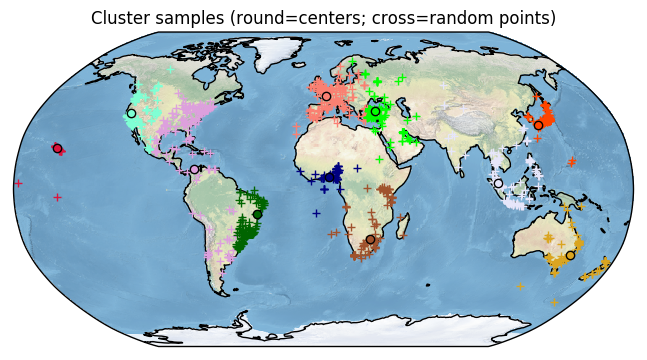

In [82]:
plot_clusters_on_map(clustering[beta_test], ordering[beta_test])

### Dynamic clustering

#### Insertion

In [110]:
def insertion(k, point_id, clustering, ordering):
    print('New point to be added : ' + str(point_id))
    for (beta, beta_clustering) in clustering.items():
        print('Inserting in the clustering of beta = ' + str(beta))
        if point_id in beta_clustering.keys():
            print('This point already exists : no changes')
            break
        centers_ids = ordering[beta]
        found = 0
        for center_id in centers_ids:
            center = id_to_coords[center_id]
            point = id_to_coords[point_id]
            if Haversine(center, point) <= 2*beta:
                print('This point belongs to the cluster of point ' + str(center_id))
                print('')
                beta_clustering[point_id] = center_id
                found = 1
                break
        if found == 0:
            if len(centers_ids) < k:
                beta_clustering[point_id] = point_id
                centers_ids.append(point_id)
                print('This point will form a new cluster')
                print('')
            else:
                print('This point is not yet affected to any cluster')
                print('')
                beta_clustering[point_id] = -1
    return clustering, ordering

In [114]:
beta_test = 1000
k = 100
dataset_ids = list(range(0, 100)) 
clustering, ordering = build_whole_clustering(k, [beta_test], dataset_ids)
new_points = random.sample(list(range(500, 1000000)), 20)
for new_point in new_points:
    clustering, ordering = insertion(k, new_point, clustering, ordering)
    print('Length of the new dataset : ' + str(len(clustering[beta_test].values())))
    n_clusters = len(ordering[beta_test])
    print('Number of clusters : ' + str(n_clusters))
    center_id = clustering[beta_test][new_point]
    if center_id != -1:
        new_point = id_to_coords[new_point]
        center = id_to_coords[center_id]
        print('Distance between the new point and its center : ' + str(Haversine(center, new_point)))
    print('')


Computing for beta = 1000

Building cluster 1 whose center is 58
99 points have been scanned 
87 points remain to be affected

Building cluster 2 whose center is 69
86 points have been scanned 
79 points remain to be affected

Building cluster 3 whose center is 93
78 points have been scanned 
54 points remain to be affected

Building cluster 4 whose center is 83
53 points have been scanned 
47 points remain to be affected

Building cluster 5 whose center is 50
46 points have been scanned 
42 points remain to be affected

Building cluster 6 whose center is 86
41 points have been scanned 
37 points remain to be affected

Building cluster 7 whose center is 99
36 points have been scanned 
23 points remain to be affected

Building cluster 8 whose center is 16
22 points have been scanned 
13 points remain to be affected

Building cluster 9 whose center is 30
12 points have been scanned 
10 points remain to be affected

Building cluster 10 whose center is 47
9 points have been scanned 
7 poin

In [115]:
beta_test = 1000
k = 5
dataset_ids = list(range(0, 100)) 
clustering, ordering = build_whole_clustering(k, [beta_test], dataset_ids)
new_points = random.sample(list(range(500, 1000000)), 20)
for new_point in new_points:
    clustering, ordering = insertion(k, new_point, clustering, ordering)
    print('Length of the new dataset : ' + str(len(clustering[beta_test].values())))
    n_clusters = len(ordering[beta_test])
    print('Number of clusters : ' + str(n_clusters))
    center_id = clustering[beta_test][new_point]
    if center_id != -1:
        new_point = id_to_coords[new_point]
        center = id_to_coords[center_id]
        print('Distance between the new point and its center : ' + str(Haversine(center, new_point)))
    print('')


Computing for beta = 1000

Building cluster 1 whose center is 19
99 points have been scanned 
80 points remain to be affected

Building cluster 2 whose center is 87
79 points have been scanned 
72 points remain to be affected

Building cluster 3 whose center is 95
71 points have been scanned 
62 points remain to be affected

Building cluster 4 whose center is 61
61 points have been scanned 
50 points remain to be affected

Building cluster 5 whose center is 4
49 points have been scanned 
46 points remain to be affected

##########################################
New point to be added : 2921
Inserting in the clustering of beta = 1000
This point belongs to the cluster of point 61

Length of the new dataset : 101
Number of clusters : 5
Distance between the new point and its center : 557.030534048

New point to be added : 721087
Inserting in the clustering of beta = 1000
This point belongs to the cluster of point 4

Length of the new dataset : 102
Number of clusters : 5
Distance between th

#### Deletion

In [231]:
def deletion(point_id, clustering, ordering):
    for beta, beta_clustering in clustering.items():
        if point_id not in beta_clustering.keys():
            break
        beta_ordering = ordering[beta]
        if point_id not in beta_ordering:
            del beta_clustering[point_id]
        else:
            del beta_clustering[point_id]
            i = beta_ordering.index(point_id)
            centers_to_recluster = beta_ordering[i:]
            beta_ordering = beta_ordering[:i]
            n_to_recluster = len(centers_to_recluster)
            centers_to_recluster.append(-1)
            points_to_recluster = [p for p, c in beta_clustering.items() if c in centers_to_recluster]
            sub_clusters, sub_order = build_beta_clustering(n_to_recluster, beta, points_to_recluster)
            beta_clustering, beta_ordering = merge(beta_clustering, beta_ordering, sub_clusters, sub_order)    
    return clustering, ordering

def merge(clusters, order, sub_clusters, sub_order):
    order = order + sub_order
    for point_id, center_id in sub_clusters.items():
        clusters[point_id] = center_id
    return clusters, order
    

In [232]:
beta_test = 1500
k = 10
dataset_ids = list(range(0, 1000)) 
clustering, ordering = build_whole_clustering(k, [beta_test], dataset_ids)

points_to_delete = random.sample(dataset_ids, 1000)

for point_id in points_to_delete:
    
    print('point to be deleted : ' + str(point_id))
    clustering, ordering = deletion(point_id, clustering, ordering)
    print('length of the new dataset : ' + str(len(clustering[beta_test].values())))
    n_clusters = len(ordering[beta_test])
    print('number of clusters : ' + str(n_clusters))
    print('')


('computing for beta = ', 1500)
building new cluster...
977 points remain to be affected
building new cluster...
862 points remain to be affected
building new cluster...
623 points remain to be affected
building new cluster...
585 points remain to be affected
building new cluster...
585 points remain to be affected
building new cluster...
478 points remain to be affected
building new cluster...
267 points remain to be affected
building new cluster...
267 points remain to be affected
building new cluster...
267 points remain to be affected
building new cluster...
267 points remain to be affected
point to be deleted : 249
length of the new dataset : 999
number of clusters : 10

point to be deleted : 535
length of the new dataset : 998
number of clusters : 10

point to be deleted : 806
length of the new dataset : 997
number of clusters : 10

point to be deleted : 234
length of the new dataset : 996
number of clusters : 10

point to be deleted : 330
length of the new dataset : 995
number o

#### Dynamic clustering

In [249]:
def generate_random_operations(max_id, length):
    operations = []
    for _ in range(0, length):
        point_id = random.choice(list(range(0, max_id)))
        operation = random.choice(['+', '-'])
        operations.append((point_id, operation))
    return operations

In [251]:
op = generate_random_operations(1000000, 10)
op

[(464441, '+'),
 (858082, '-'),
 (126054, '-'),
 (740284, '+'),
 (959181, '-'),
 (201961, '+'),
 (100840, '-'),
 (534763, '-'),
 (96035, '-'),
 (237257, '-')]

In [257]:
def dynamic_clustering(operations, initial_dataset, betas, k):
    clustering, ordering = build_whole_clustering(k, betas, initial_dataset)
    print(clustering, ordering)
    for point_id, operation in operations:
        if operation == '+':
            clustering, ordering = insertion(k, point_id, clustering, ordering)
        else:
            clustering, ordering = deletion(point_id, clustering, ordering)
    print(clustering, ordering)
    return clustering, ordering

In [258]:
initial_dataset = random.sample(list(range(0, 1000000)), 100)
operations = generate_random_operations(1000000, 10)
betas = [1000, 1500]
k = 8
clustering, ordering = dynamic_clustering(operations, initial_dataset, betas, k)

('computing for beta = ', 1000)
building new cluster...
84 points remain to be affected
building new cluster...
72 points remain to be affected
building new cluster...
72 points remain to be affected
building new cluster...
62 points remain to be affected
building new cluster...
62 points remain to be affected
building new cluster...
62 points remain to be affected
building new cluster...
44 points remain to be affected
building new cluster...
39 points remain to be affected
('computing for beta = ', 1500)
building new cluster...
84 points remain to be affected
building new cluster...
76 points remain to be affected
building new cluster...
59 points remain to be affected
building new cluster...
53 points remain to be affected
building new cluster...
39 points remain to be affected
building new cluster...
39 points remain to be affected
building new cluster...
29 points remain to be affected
building new cluster...
19 points remain to be affected
({1000: {479744: 428841, 940554: -1, 115